In [1]:
from tqdm import tqdm
from typing import List, Dict
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from flowprintOptimal.sekigo.core.flowRepresentation import FlowRepresentation,PacketFlowRepressentation
from flowprintOptimal.sekigo.dataAnalysis.vNATDataFrameProcessor import VNATDataFrameProcessor
from flowprintOptimal.sekigo.core.flowConfig import FlowConfig
import random
from flowprintOptimal.sekigo.flowUtils.flowDatasets import PacketFlowDataset
from torch.utils.data import Dataset,DataLoader
from torchsampler import ImbalancedDatasetSampler
from sklearn.model_selection import train_test_split
from flowprintOptimal.sekigo.flowUtils.commons import normalizePacketRep
import os
from joblib import Parallel, delayed
from flowprintOptimal.sekigo.flowUtils.commons import saveFlows,loadFlows
from flowprintOptimal.sekigo.dataAnalysis.dataFrameProcessor import UTMobileNetProcessor
from flowprintOptimal.sekigo.flowUtils.dataGetter import getTrainTestOOD
from sklearn.metrics import confusion_matrix
import json
from flowprintOptimal.sekigo.modeling.trainers import NNClassificationTrainer
from flowprintOptimal.sekigo.modeling.neuralNetworks import LSTMNetwork,TransformerGenerator,CNNNetwork1D
from flowprintOptimal.sekigo.modeling.loggers import Logger
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
from flowprintOptimal.sekigo.earlyClassification.DQL.core import MemoryElement,Rewarder,State
from flowprintOptimal.sekigo.earlyClassification.DQL.memoryFiller import MemoryFiller
from flowprintOptimal.sekigo.earlyClassification.DQL.datasets import MemoryDataset
from flowprintOptimal.sekigo.earlyClassification.DQL.trainers import EarlyClassificationtrainer
from flowprintOptimal.sekigo.utils.documentor import Documenter
from flowprintOptimal.sekigo.utils.evaluations import Evaluator,EarlyEvaluation
import warnings
from flowprintOptimal.sekigo.flowUtils.commons import dropPacketFromPacketRep
warnings.filterwarnings('ignore')

In [19]:
configs = dict(
    name = "UTMobileNet2021_no_sample_ood_alpha_ood_samples",
    description = "UTMobileNet2021 with OOD detection (no balancers used) no ood samples generated alpha of .5 and hint gap at .05 with ood samples",
    
    common_config = dict(
        max_length = 15
    ),
    
    full_model_kwargs = dict(
        lstm_hidden_size = 256,
        layers= 2, lstm_input_size = 3
    ),

    early_model_kwargs = dict(
        lstm_input_size= 3,lstm_hidden_size= 256,layers = 2        
    ),
    
    data_config = dict(
        dataset_name = "UTMobileNet2021",
        subsampleConfig = None,#dict(max_gap = 20, min_gap = 5),
        max_flow_length = 80, # in seconds  ( each flow sample cannot excede this length)
        test_size = .2,
        ood_classes = ["google-maps", "youtube","messenger"],
        do_balance = False

    ),

    rewarder_config = dict(
        l = .5
    ),

    dataset_config = dict(
        aug = [0,.2]
    ),

    memory_fillter_config = dict(
        ood_config = dict(ood_aug = [.6,.9], ood_prob = .2),
        min_length = 5,
        use_balancer = False
    ),
    full_trainer_config = dict(
        use_sampler = False
    ),
    early_trainer_config = dict(
        use_sampler = False  # this is for giving more weight to wait samples
    )


)

In [3]:
"""
# code to read and save packet flow reps UTMobileNet2021
utc_mobile_processor = UTMobileNetProcessor(base_path= "data/UTMobileNet2021")
flows = utc_mobile_processor.processData()
saveFlows(path  = "data/UTMobileNet2021/mobilenetPacketRep.json", flows = flows)
"""

'\n# code to read and save packet flow reps UTMobileNet2021\nutc_mobile_processor = UTMobileNetProcessor(base_path= "data/UTMobileNet2021")\nflows = utc_mobile_processor.processData()\nsaveFlows(path  = "data/UTMobileNet2021/mobilenetPacketRep.json", flows = flows)\n'

In [4]:
train_flows,test_flows,ood_flows = getTrainTestOOD(**configs["data_config"], packet_limit= configs["common_config"]["max_length"])

full class distrubation
google-maps     3256
netflix         2081
reddit          1609
facebook        1312
youtube         1309
pinterest       1233
instagram       1222
spotify          878
google-drive     877
twitter          847
gmail            511
hangout          426
messenger        411
Name: count, dtype: int64
using no sampling
filtering max_flow_length = 80
post num packet filter class distrubation
google-maps     3256
netflix         2081
reddit          1609
facebook        1312
youtube         1309
pinterest       1233
instagram       1222
spotify          878
google-drive     877
twitter          847
gmail            511
hangout          426
messenger        409
Name: count, dtype: int64
------------------------------
train class distrubation
netflix         1658
reddit          1289
facebook        1027
pinterest        976
instagram        975
spotify          711
google-drive     702
twitter          674
gmail            426
hangout          358
Name: count, dtype: i

In [5]:
train_dataset = PacketFlowDataset(flows= train_flows,label_to_index= None,aug= configs["dataset_config"]["aug"])
test_dataset = PacketFlowDataset(flows= test_flows,label_to_index= train_dataset.label_to_index)
ood_dataset = PacketFlowDataset(flows= ood_flows, label_to_index= None) if (ood_flows != None and len(ood_flows) != 0) else None

In [20]:
num_labels = len(train_dataset.label_to_index)
configs["full_model_kwargs"]["output_dim"] = num_labels 
configs["early_model_kwargs"]["output_dim"] = num_labels + 1
configs["rewarder_config"]["num_labels"] = num_labels
configs["rewarder_config"]["max_length"] = configs["common_config"]["max_length"]

In [14]:
#classifier_ = CNNNetwork1D( **configs["full_model_kwargs"])#LSTMNetwork(lstm_hidden_size= 64,lstm_input_size=6,output_dim = len(all_train_dataset.label_to_index))
classifier_ = LSTMNetwork(**configs["full_model_kwargs"])
logger= Logger(name= "classification",verbose= True)
logger.default_step_size = 500
classification_trainer = NNClassificationTrainer(classifier = classifier_,device= device,logger= logger)
classification_trainer.train(train_dataset= train_dataset,test_dataset= test_dataset,epochs=200,batch_size= 64,lr= .0003,use_balanced_sampler= configs["full_trainer_config"]["use_sampler"])

classification ---- 1 metric test_f1 = 0.014736842105263156
classification ---- 1 metric test_accuracy = 0.07954545454545454
classification ---- 1 metric train_accuracy = 0.07980900409276943
classification ---- 1 metric train_f1 = 0.014782059380922299
classification ---- 10 metric train_loss = 2.2860644817352296
classification ---- 20 metric train_loss = 2.2491039991378785
classification ---- 30 metric train_loss = 2.214844560623169
classification ---- 40 metric train_loss = 2.2170629501342773
classification ---- 50 metric train_loss = 2.167871189117432
classification ---- 60 metric train_loss = 2.137901473045349
classification ---- 70 metric train_loss = 2.063964879512787
classification ---- 80 metric train_loss = 1.9758317708969115
classification ---- 90 metric train_loss = 1.9700603008270263
classification ---- 100 metric train_loss = 1.8896385192871095
classification ---- 110 metric train_loss = 1.9407173633575439
classification ---- 120 metric train_loss = 1.9106585741043092
class

In [15]:
classification_trainer.best["score"]

0.9267673565051963

In [20]:
print(test_dataset.label_to_index)

{'facebook': 0, 'pinterest': 1, 'hangout': 2, 'netflix': 3, 'google-drive': 4, 'gmail': 5, 'instagram': 6, 'spotify': 7, 'reddit': 8, 'twitter': 9}


In [21]:
Evaluator(model= classification_trainer.best["model"], device=device).getMetrices(dataset= test_dataset)

{'micro_f1': 0.92,
 'macro_f1': 0.9217255738658713,
 'accuracy': 0.92,
 'cm': array([[246,   0,   0,   1,   0,   0,   2,   0,   6,   0],
        [  6, 211,   0,   0,   1,   0,   1,   0,  37,   3],
        [  0,   0,  72,   1,   0,   0,   0,   3,   0,   1],
        [  3,   4,   0, 401,   2,   0,   5,   0,   4,   1],
        [  2,   1,   0,   0, 163,   1,   1,   0,   0,   1],
        [  5,   1,   0,   0,   1,  94,   1,   0,   1,   4],
        [ 11,   0,   1,   1,   1,   1, 193,   1,   6,   1],
        [  1,   0,   1,   0,   1,   0,   3, 158,  11,   2],
        [  9,  10,   0,   0,   1,   0,   2,   0, 327,   2],
        [  2,   1,   3,   1,   1,   0,   0,   0,   2, 159]]),
 'incorrect_ood': 0.0}

In [21]:
class Rewarder:
    def __init__(self,max_length,l,num_labels : int):
        self.max_length = max_length
        self.l = l # l is smaller than 1
        self.num_labels = num_labels

    def reward(self,state : State,action : int):
        if state.label == action:
            # reward 1 on a correct prediction
            return 1, True
        else:
            # either incorrect or wait
            # wait 
            # treat the wait action with a negative reward
            if action == self.num_labels:
                if state.length == self.max_length:
                    # it is the last timestamp
                    if state.label == -1:
                        return -self.l/self.max_length, True#-self.l*(state.length/self.max_length),True
                    else:
                        return -1, True
                else:
                    return  -self.l/self.max_length, False#-self.l*(state.length/self.max_length), False
            else:
                # incorrect
                return -1,True

In [22]:
rewarder = Rewarder(**configs["rewarder_config"])
memory_filler = MemoryFiller(dataset= train_dataset,rewarder= rewarder, min_length= configs["memory_fillter_config"]["min_length"],
                              max_length= rewarder.max_length,ood_config= configs["memory_fillter_config"]["ood_config"], use_balancer= configs["memory_fillter_config"]["use_balancer"]
                              )

In [23]:
memory = memory_filler.processDataset()
print(len(memory))

2128632


In [24]:
memory_dataset = MemoryDataset(memories= memory,num_classes= len(train_dataset.label_to_index),
                               min_length= memory_filler.min_length,max_length= memory_filler.max_length)
predictor = LSTMNetwork(**configs["early_model_kwargs"])
logger = Logger(verbose= True)
logger.default_step_size = 1000

In [25]:
labels = []

for m in memory_dataset:
    labels.append(m["label"])

print(pd.Series(labels).value_counts())

 1    360701
 4    279147
 5    224818
-1    215501
 0    211387
 6    209814
 9    153912
 3    152581
 2    147983
 8     94501
 7     78287
Name: count, dtype: int64


In [26]:
ddq_model = EarlyClassificationtrainer(predictor= predictor,train_dataset = train_dataset,test_dataset= test_dataset,memory_dataset= memory_dataset,hint_loss_gap= .05,
                                       ood_dataset= ood_dataset,hint_loss_alpha= .5,q_loss_alpha= 1,use_sampler= configs["early_trainer_config"]["use_sampler"],
                                       logger= logger,device=device,model_replacement_steps= 500)

In [27]:
ddq_model.train(epochs= 20,batch_size= 128,lr= .0003,lam= .99) 

 ---- 1000 metric q_loss = 0.31719836155325176
 ---- 1000 metric hint_loss = 0.001989176519215107
 ---- 1 metric test_eval_f1 = 0.0
 ---- 1 metric test_eval_time = 15.0
 ---- 1 metric incorrect_ood_test = 1.0
 ---- 1 metric ood_eval = 1.0
 ---- 1 metric ood_eval_time = 15.0
 ---- 2000 metric q_loss = 0.30982620334625244
 ---- 2000 metric hint_loss = 0.02853160620853305
 ---- 2 metric test_eval_f1 = 0.0
 ---- 2 metric test_eval_time = 15.0
 ---- 2 metric incorrect_ood_test = 1.0
 ---- 2 metric ood_eval = 1.0
 ---- 2 metric ood_eval_time = 15.0
 ---- 1 metric train_eval_f1 = 0.0
 ---- 1 metric train_eval_time = 15.0
 ---- 1 metric incorrect_ood_train = 1.0
 ---- 3000 metric q_loss = 0.3177563038319349
 ---- 3000 metric hint_loss = 0.057243482571095225
 ---- 3 metric test_eval_f1 = 0.1635776544466814
 ---- 3 metric test_eval_time = 13.99
 ---- 3 metric incorrect_ood_test = 0.2863636363636364
 ---- 3 metric ood_eval = 0.9985926819461198
 ---- 3 metric ood_eval_time = 15.0
 ---- 4000 metric

In [22]:
documenter = Documenter(train_dataset= train_dataset,test_dataset= test_dataset, ood_dataset= ood_dataset,full_model= classification_trainer.best["model"], early_model= ddq_model.best["model"],
                        configs= configs
                        )

In [23]:
documenter.document(name= configs["name"])

In [28]:
EarlyEvaluation(min_steps= 5,device= device,model= ddq_model.predictor).getMetrices(dataset= test_dataset, ood_dataset= ood_dataset)

{'micro_f1': 0.8836363636363637,
 'macro_f1': 0.8103467652435339,
 'accuracy': 0.8836363636363637,
 'cm': array([[191,   1,   3,   0,   6,  35,   5,   0,   0,   0],
        [  0, 408,   0,   1,   4,   2,   0,   0,   2,   0],
        [  0,   3, 159,   1,   2,   0,   2,   1,   0,   3],
        [  0,   1,   1, 168,   2,   0,   2,   0,   0,   0],
        [  0,  15,   0,   1, 280,  11,   4,   1,   1,   6],
        [ 15,   5,   0,   2,   5, 255,   1,   0,   0,   0],
        [  1,   4,   0,   1,  37,   2, 204,   0,   3,   4],
        [  0,   1,   0,   0,   0,   1,   0,  66,   0,   0],
        [  0,  14,   0,   2,   0,   0,   0,   0,  68,   0],
        [  0,   1,   7,   0,   6,   0,   1,   4,   0, 145]]),
 'incorrect_ood': 0.010454545454545454,
 'time': 11.312272727272727,
 'ood_accuracy': 0.779654201849618,
 'ood_time': 14.231202251708886}

In [29]:
EarlyEvaluation(min_steps= 5,device= device,model= ddq_model.best["model"]).getMetrices(dataset= test_dataset,ood_dataset= ood_dataset)

{'micro_f1': 0.9040909090909091,
 'macro_f1': 0.8343719578534892,
 'accuracy': 0.9040909090909091,
 'cm': array([[204,   1,   0,   0,   9,  23,   3,   0,   0,   0],
        [  1, 404,   0,   1,   8,   2,   0,   0,   0,   0],
        [  0,   1, 160,   1,   7,   0,   1,   0,   0,   1],
        [  0,   1,   0, 170,   1,   0,   1,   0,   0,   0],
        [  1,   2,   2,   0, 297,   9,   2,   1,   0,   3],
        [ 11,   0,   1,   2,   9, 259,   0,   0,   0,   0],
        [  0,   1,   0,   1,  39,   2, 206,   0,   1,   3],
        [  0,   0,   0,   1,   0,   1,   0,  65,   0,   0],
        [  0,   0,   0,   3,   1,   0,   0,   0,  80,   0],
        [  0,   0,   2,   0,  13,   0,   1,   4,   0, 144]]),
 'incorrect_ood': 0.015,
 'time': 11.293181818181818,
 'ood_accuracy': 0.8132287897064736,
 'ood_time': 14.502412545235224}

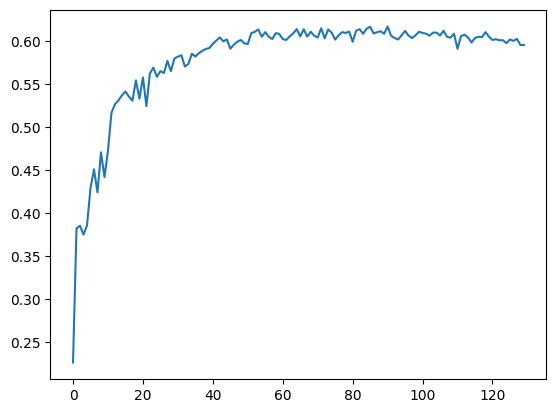

In [ ]:
plt.plot(logger.getMetric("test_eval_f1"))

In [ ]:
res = ddq_model.eval(dataset= test_dataset)
res

RuntimeError: CUDA error: unspecified launch failure
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
preds = ddq_model.predictOnDataset(dataset= test_dataset)
preds = np.array(preds)[:,0]
labels = list(map(lambda x : x["label"], test_dataset))

In [ ]:
preds[(preds == -1)] = 0

In [ ]:
test_dataset.label_to_index

{'BROWSERS': 0, 'P2P': 1, 'OTHER': 2, 'Skype': 3, 'MAIL': 4}

In [ ]:


confusion_matrix(y_true= labels,y_pred= preds)

array([[1796,    6,  302,  347,    6],
       [  23, 2398,   17,    8,    8],
       [ 501,   10, 1258,  209,   21],
       [ 195,   12,   63, 1811,    3],
       [  66,   13,   22,   16, 1113]])

In [ ]:
test_dataset.label_to_index
index_to_label = {x:y for y,x in test_dataset.label_to_index.items()}

In [ ]:
labels = np.array(test_dataset.get_labels())
unique_labels = np.unique(labels)
res = ddq_model.predictOnDataset(test_dataset)
res = np.array(res)[:,1]

In [ ]:
ut_dct = dict()
for label in unique_labels:
    ut_dct[index_to_label[label]] =  res[labels == label].mean()

In [ ]:
ut_dct

{'google-maps': 9.732919254658386,
 'youtube': 11.95539033457249,
 'instagram': 12.003968253968255,
 'pinterest': 9.855371900826446,
 'spotify': 11.63953488372093,
 'facebook': 11.846456692913385,
 'google-drive': 8.884146341463415,
 'twitter': 10.19186046511628,
 'netflix': 9.655581947743467,
 'reddit': 11.238235294117647,
 'hangout': 8.974025974025974,
 'messenger': 12.655913978494624,
 'gmail': 11.673684210526316}

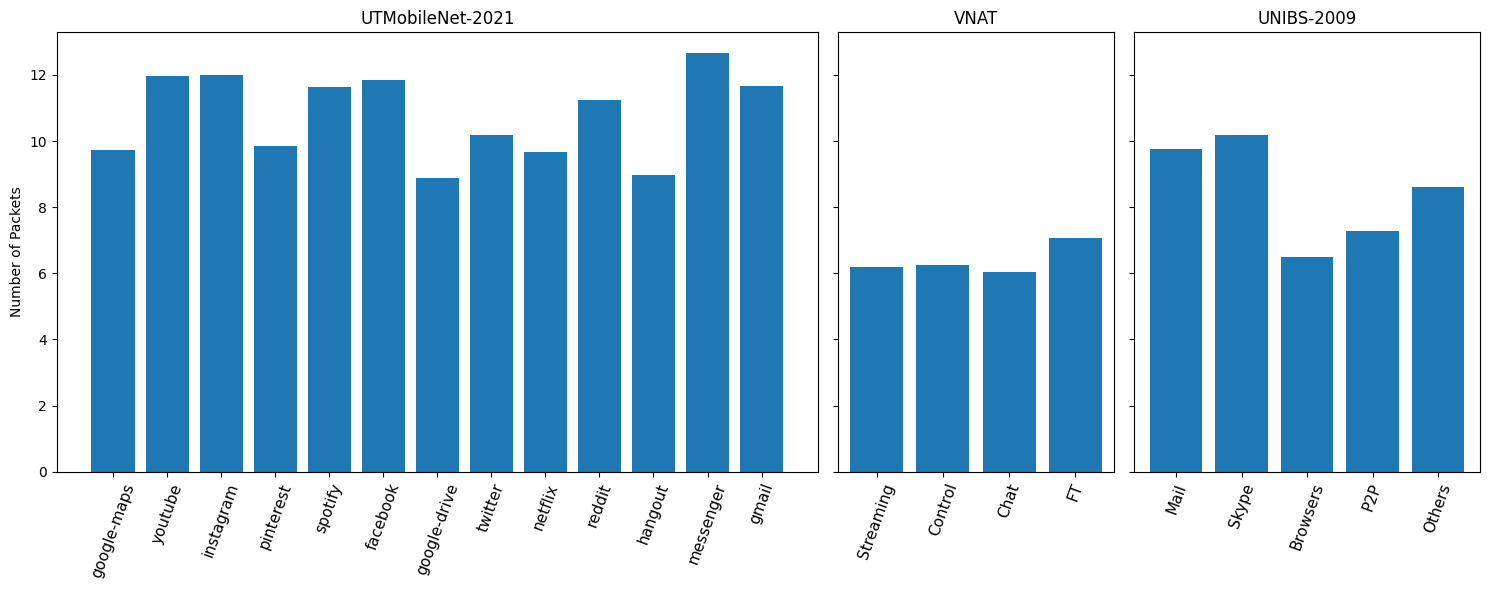

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec

def getDataDct(dct):
    X,y = [],[]
    for key,value in dct.items():
        X.append(key)
        y.append(value)
    return X,y
# Sample data for 4 datasets, each containing classes and corresponding values
class_data = {
    'UTMobileNet-2021': ut_dct,
    'VNAT': {'Streaming': 6.19, 'Control': 6.25, 'Chat': 6.05, 'FT': 7.07},
    'UNIBS-2009': {'Mail': 9.75, 'Skype': 10.17, 'Browsers': 6.48, 'P2P': 7.28, 'Others': 8.62},
}



f, axes = plt.subplots(1, len(class_data), sharex='col', sharey='row', figsize=(15, 6),gridspec_kw={'width_ratios':[11,4,5]})

for i,dataset in enumerate(class_data):
    X,y = getDataDct(class_data[dataset])
    axes[i].bar(X,y)
    axes[i].set_title(dataset)
    axes[i].tick_params(axis='x', rotation=70,labelsize = 11)
    if i == 0:
        axes[i].set_ylabel('Number of Packets')  # Set y-axis label



plt.tight_layout()
plt.show()


In [ ]:
res[labels == 0].mean()

9.732919254658386

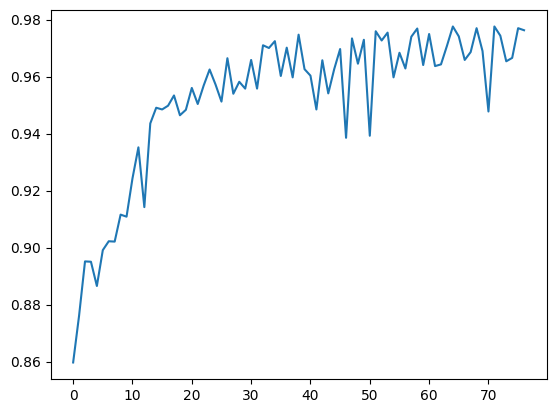

In [ ]:
plt.plot(logger.getMetric("test_eval_f1"))

In [ ]:
np.argmax(np.array(logger.getMetric(metric_name= "test_eval_f1")))

64

In [ ]:
logger.getMetric(metric_name= "test_eval_time")[64]

7.814477468839885

In [ ]:
logger.getMetric(metric_name= "test_eval_f1")[64]

0.9775886864813039